# Training QBM with Gaussian shot noise

In this notebook, we test how Gaussian shot noise affects on the QBM training. The noise is due to the measurements of QMB and/or target expectation values, which are respectively refered to as $\kappa$ and $\xi$, in ["On the Sample Complexity of Quantum Boltzmann Machine Learning"](http://arxiv.org/abs/2306.14969).

The XXZ model Hamiltonian in 1D is

$$
\mathcal{H}_{\mathrm{XXZ}}=\sum_{i=1}^{n-1} J\left(\sigma_i^x \sigma_{i+1}^x+\sigma_i^y \sigma_{i+1}^y\right)+\Delta \sigma_i^z \sigma_{i+1}^z+\sum_{i=1}^n h_z \sigma_i^z
$$

and the target state is

$$
\eta=\frac{e^{\mathcal{H}_{\mathrm{XXZ}}}}{Z}
$$

We choose the parameters

* $J=-0.5$
* $\Delta=-0.7$
* $h_z=-0.8$

In [1]:
J = -0.5
Delta = -0.7
hz = -0.8

## Define the parameters of the model: QBM

Here we select the number of qubits of the Gibbs state, the model Hamiltonian to use in the definition of the QBM, and the training hyperparameters. We do not add noise to the training.

In [2]:
import numpy as np

##########
# CONFIG #
##########

rng = np.random.default_rng(seed=1)

n_qubits = 4
model_label = 6  # 6: Geometrically local 1D chain
depolarizing_noise = 0.0  # if noisy expectation values
learning_rate = 0.2
epochs = 1000
eps = 1e-6
compute_qre = True
sigma = 0.1  # Standard deviation due to the Gaussian shot noise

The model Hamiltonian is defined as a list of operators $H = \sum_{i=0}^m \theta_i H_i $

In [3]:
from qbm_quimb import hamiltonians

# A list of operators in the model Hamiltonian
model_ham_ops, model_ham_names = hamiltonians.hamiltonian_operators(
    n_qubits, model_label, return_names=True
)

We have `m` terms in the Hamiltonian

In [4]:
m = len(model_ham_names)
print(m)

21


## Define the data

Here we work with _quantum_ data in the form of the Gibbs state of a target Hamiltonian at a fixed inverse temperature $\beta$.
The target Hamiltonian is a subset of the model Hamiltonian.


In [5]:
from qbm_quimb import data

########
# DATA #
########

# We use the label 6 to generate the terms in the target hamiltonian
# but we fix them using J, Delta, and hz
target_label = 6
target_params = np.array(3 * [J] + 4 * [0] + 3 * [J] + 4 * [0] + 3 * [Delta] + 4 * [hz])
target_beta = -1.0  # use -1 to match with the definition of the thermal state

In [6]:
target_params.shape

(21,)

In [7]:
# generate expectation values: quantum data
target_expects, target_state = data.generate_data(
    n_qubits,
    target_label,
    target_params,
    target_beta,
    model_ham_ops,
    depolarizing_noise,
)

The expectation values of the model Hamiltonian operators are computed with respect to the target Gibbs state.

In [8]:
target_expects  # expectation values w.r.t. target density matrix

[-0.4656640001798008,
 -0.4473469096987973,
 -0.46566400017980125,
 4.3845086613330065e-17,
 6.914681537656912e-17,
 -7.962046540739132e-17,
 5.21593229966328e-18,
 -0.4656640001798008,
 -0.4473469096987973,
 -0.46566400017980125,
 2.7733391199176196e-32j,
 3.4666738998970245e-33j,
 -3.851859888774472e-33j,
 4.7955655615242173e-32j,
 -0.4086864138659327,
 -0.4919460461791575,
 -0.40868641386593313,
 -0.37920165144017504,
 -0.11550306008696522,
 -0.11550306008696494,
 -0.37920165144017476]

Text(0, 0.5, 'Expectation values')

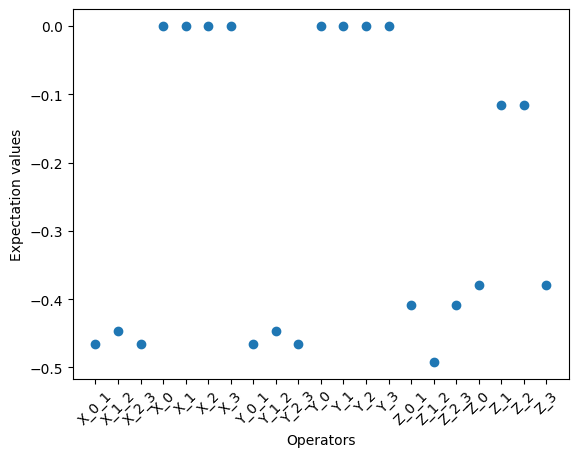

In [19]:
import matplotlib.pyplot as plt

plt.plot(np.asarray(target_expects).real, "o")
plt.xticks(np.arange(len(model_ham_names)), model_ham_names, rotation=45)
plt.xlabel("Operators")
plt.ylabel("Expectation values")

## Start the training by minimizing the relative entropy

We initialize the parameters of the model QBM and then train with stochastic gradient descent (SGD)

In [9]:
from qbm_quimb.training import QBM, train_qbm


#############
# QBM Model #
#############

initial_params = rng.normal(size=len(model_ham_ops))
qbm_state = QBM(model_ham_ops, initial_params)
print(f"Initial parameters: {qbm_state.get_coeffs()}")
print(f"Target parameters: {target_params}")
print(f"Target beta: {target_beta}")

Initial parameters: [ 0.34558419  0.82161814  0.33043708 -1.30315723  0.90535587  0.44637457
 -0.53695324  0.5811181   0.3645724   0.2941325   0.02842224  0.54671299
 -0.73645409 -0.16290995 -0.48211931  0.59884621  0.03972211 -0.29245675
 -0.78190846 -0.25719224  0.00814218]
Target parameters: [-0.5 -0.5 -0.5  0.   0.   0.   0.  -0.5 -0.5 -0.5  0.   0.   0.   0.
 -0.7 -0.7 -0.7 -0.8 -0.8 -0.8 -0.8]
Target beta: -1.0


The training is performed with the Gaussian shot noise, which is represetend by a random variable sampled from a Normal distribution with mean and standard deviation sigma.

In [10]:
################
# QBM Taininig #
################

target_eta = None
if compute_qre:
    target_eta = target_state

qbm_state, max_grads_hist, qre_hist = train_qbm(
    qbm=qbm_state,
    target_expects=target_expects,
    learning_rate=learning_rate,
    epochs=epochs,
    eps=eps,
    sigma=sigma,
    compute_qre=compute_qre,
    target_eta=target_eta,
)

print(f"Trained parameters: {qbm_state.get_coeffs()}")
print(f"Max. gradients: {max_grads_hist[-1]}")
if compute_qre:
    print(f"Initial relative entropy: {qre_hist[0]}")
    print(f"Trained relative entropy: {qre_hist[-1]}")

Trained parameters: [-4.09940545e-01+0.00000000e+00j -4.62029614e-01+0.00000000e+00j
 -5.45398467e-01+0.00000000e+00j -3.46611507e-02+0.00000000e+00j
  1.02034939e-02+0.00000000e+00j -3.02255768e-02+0.00000000e+00j
 -7.13194158e-03+0.00000000e+00j -5.15902769e-01+0.00000000e+00j
 -5.06475031e-01+0.00000000e+00j -4.87096663e-01+0.00000000e+00j
 -5.32156702e-02+5.54667824e-30j  3.62538976e-02+6.93334780e-31j
 -3.78472210e-04-7.70371978e-31j  1.46353686e-03+9.59113112e-30j
 -7.30830153e-01+0.00000000e+00j -6.79224838e-01+0.00000000e+00j
 -6.78828541e-01+0.00000000e+00j -9.30373875e-01+0.00000000e+00j
 -8.47695196e-01+0.00000000e+00j -8.17304724e-01+0.00000000e+00j
 -8.32050694e-01+0.00000000e+00j]
Max. gradients: 0.21129709495528745
Initial relative entropy: 4.6055938792049025
Trained relative entropy: 0.05503000810323577


The relative entropy after training is close to zero, and this is reproducing the left side of panel (a) in Figure 2 of the paper.

## Plot training history

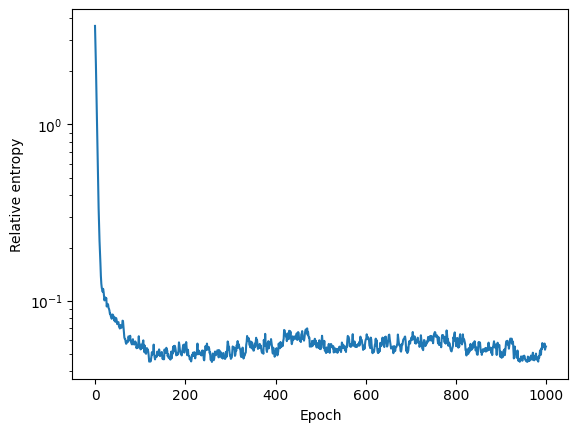

In [11]:
if compute_qre:
    plt.plot(qre_hist[1:], "-")
    plt.xlabel("Epoch")
    plt.ylabel("Relative entropy")
    plt.yscale("log")
    plt.show()

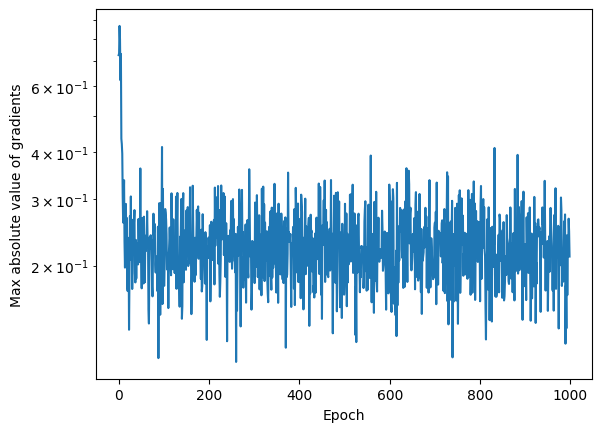

In [12]:
plt.plot(max_grads_hist[1:], "-")
plt.xlabel("Epoch")
plt.ylabel("Max absolute value of gradients")
plt.yscale("log")
plt.show()

## Compare the parameters

In [13]:
# target parameters
print(target_params)

[-0.5 -0.5 -0.5  0.   0.   0.   0.  -0.5 -0.5 -0.5  0.   0.   0.   0.
 -0.7 -0.7 -0.7 -0.8 -0.8 -0.8 -0.8]


In [14]:
# model parameters
print(qbm_state.get_coeffs())

[-4.09940545e-01+0.00000000e+00j -4.62029614e-01+0.00000000e+00j
 -5.45398467e-01+0.00000000e+00j -3.46611507e-02+0.00000000e+00j
  1.02034939e-02+0.00000000e+00j -3.02255768e-02+0.00000000e+00j
 -7.13194158e-03+0.00000000e+00j -5.15902769e-01+0.00000000e+00j
 -5.06475031e-01+0.00000000e+00j -4.87096663e-01+0.00000000e+00j
 -5.32156702e-02+5.54667824e-30j  3.62538976e-02+6.93334780e-31j
 -3.78472210e-04-7.70371978e-31j  1.46353686e-03+9.59113112e-30j
 -7.30830153e-01+0.00000000e+00j -6.79224838e-01+0.00000000e+00j
 -6.78828541e-01+0.00000000e+00j -9.30373875e-01+0.00000000e+00j
 -8.47695196e-01+0.00000000e+00j -8.17304724e-01+0.00000000e+00j
 -8.32050694e-01+0.00000000e+00j]


Text(0, 0.5, 'Paramters -> |target - model|')

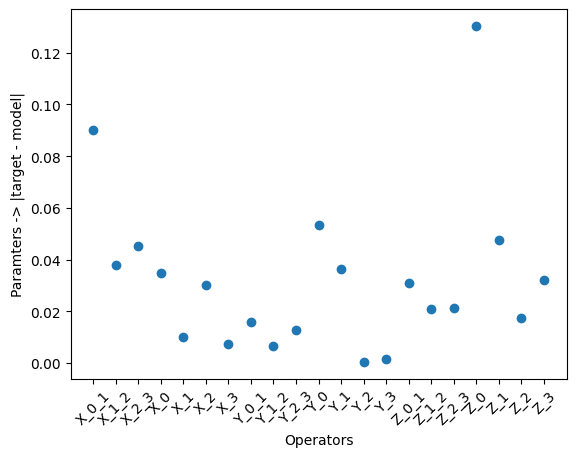

In [15]:
param_diff = np.fabs(target_params.real - qbm_state.get_coeffs().real)
plt.plot(param_diff, "o")
plt.xticks(np.arange(len(model_ham_names)), model_ham_names, rotation=45)
plt.xlabel("Operators")
plt.ylabel("Paramters -> |target - model|")

## Check fidelity with the Gibbs state

In [16]:
target_eta

[[ 4.570858e-05+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j
   0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j
   0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j]
 [ 0.000000e+00+0.j  1.870587e-03+0.j -2.887053e-03+0.j  0.000000e+00+0.j  1.560978e-03+0.j  0.000000e+00+0.j
   0.000000e+00+0.j  0.000000e+00+0.j -3.790343e-04+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j
   0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j]
 [ 0.000000e+00+0.j -2.887053e-03+0.j  7.473439e-03+0.j  0.000000e+00+0.j -5.451457e-03+0.j  0.000000e+00+0.j
   0.000000e+00+0.j  0.000000e+00+0.j  1.560978e-03+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j
   0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j]
 [ 0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j  1.476248e-02+0.j  0.000000e+00+0.j -4.224198e-02+0.j
   1.

In [17]:
qbm_state.get_density_matrix()

[[ 4.320793e-05+0.000000e+00j  1.018760e-05-1.531820e-05j -3.302394e-05+5.092805e-05j -1.425410e-05+1.165839e-06j
   3.564316e-05-7.403015e-05j -2.252924e-04-7.836097e-06j  3.838244e-04+1.223399e-05j -8.189717e-06+1.768171e-05j
  -1.751012e-05+4.228610e-05j  2.980547e-04+9.480525e-06j -7.708812e-04-2.472241e-05j  1.570617e-05-2.965323e-05j
   2.803369e-04+8.719457e-06j  8.754100e-06-7.275543e-06j -2.573498e-05+2.712079e-05j -2.362098e-05-9.522604e-07j]
 [ 1.018760e-05+1.531820e-05j  1.632481e-03-2.131252e-20j -2.358183e-03-8.783736e-07j -2.118235e-04+4.491864e-04j
   1.246146e-03-4.646660e-06j  8.133684e-04-1.958974e-03j -4.987139e-04+1.110471e-03j  9.582999e-04+4.584798e-05j
  -2.917756e-04+6.029705e-06j -6.786842e-04+1.420268e-03j  8.581817e-04-1.619019e-03j -2.870111e-03-1.018636e-04j
  -1.831686e-04+3.441131e-04j  4.258738e-03+1.348439e-04j -1.869660e-03-6.771284e-05j -9.496255e-05+8.760281e-05j]
 [-3.302394e-05-5.092805e-05j -2.358183e-03+8.783736e-07j  5.723807e-03-7.158764e-20j 

In [18]:
from quimb import fidelity

fidelity(target_eta, qbm_state.get_density_matrix())

0.9977924141959099

Since the QBM model contains the operators of the Hamiltonian used to create the target quantum Gibbs state as a subset, the training is able to find the parameters correctly. Therefore the fidelity between the target state and the QBM state after training is 1.